In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import svm
from sklearn.decomposition import KernelPCA, PCA
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, cohen_kappa_score, confusion_matrix
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier

In [2]:
winequality_data = pd.read_csv("winequality-white.csv").dropna()

winequality_data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [3]:
winequality_data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [4]:
y = winequality_data["quality"]
X = winequality_data.loc[:, winequality_data.columns != "quality"]

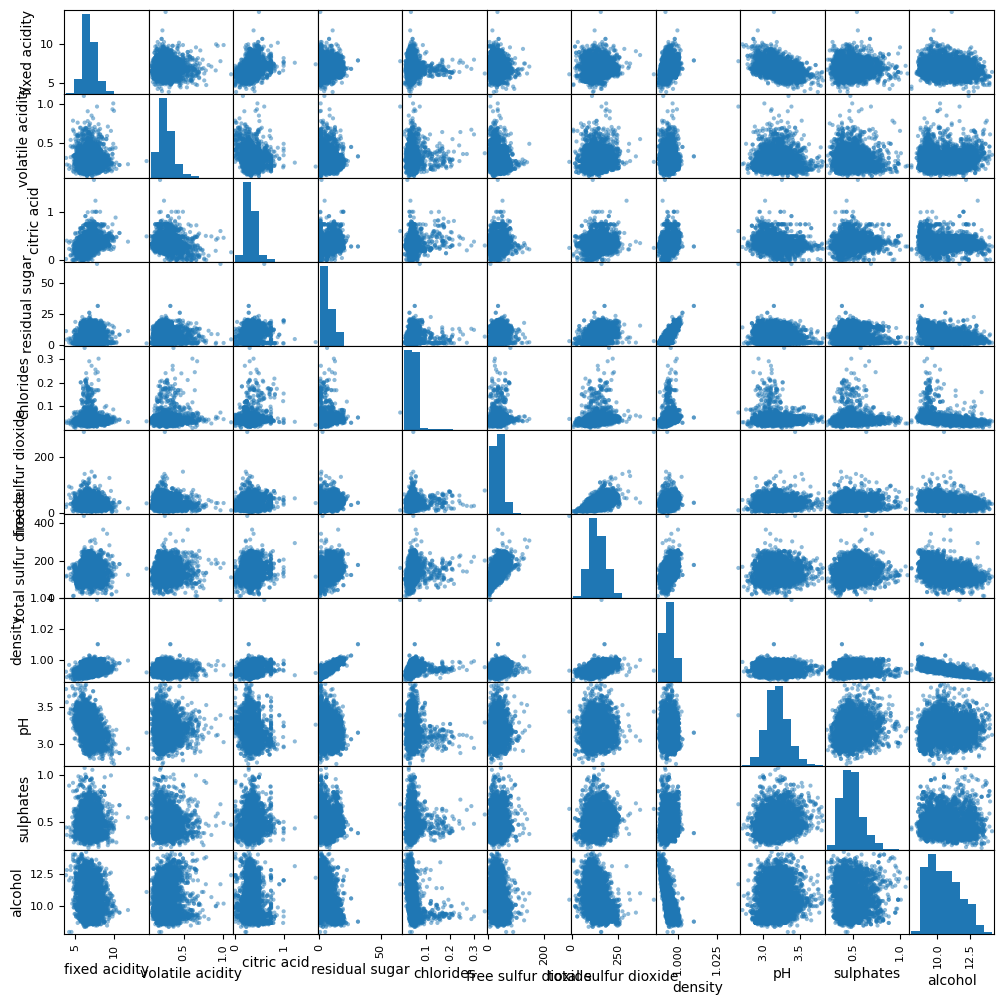

In [5]:
pd.plotting.scatter_matrix(X, figsize=(12, 12))
plt.show()

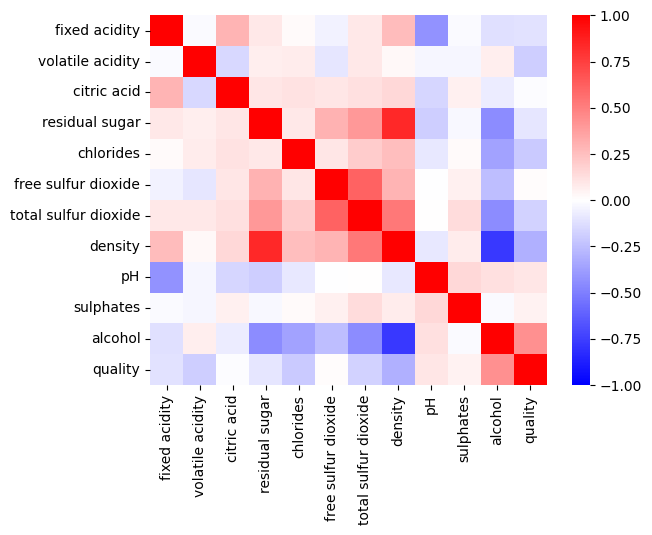

In [6]:
sns.heatmap(winequality_data.corr(), cmap="bwr", vmin=-1, vmax=1)

plt.show()

In [7]:
seed = 11
test_pct = 0.20

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_pct, random_state=seed
)

In [20]:
pca = make_pipeline(
    StandardScaler(),
    KernelPCA(n_components=10, kernel="rbf", gamma=0.02, random_state=seed),
    # svm.SVC(random_state=seed),
)

X_pca = pd.DataFrame(pca.fit_transform(X_train), columns=pca.get_feature_names_out())

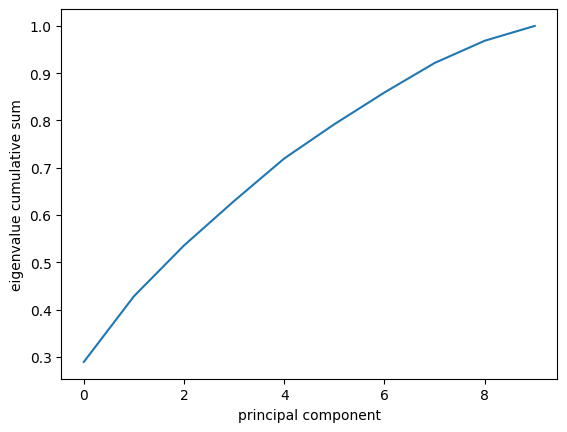

In [36]:
explained_variance = pca["kernelpca"].eigenvalues_
explained_variance_ratio = explained_variance / explained_variance.sum()

plt.plot(np.cumsum(explained_variance_ratio))
plt.ylabel("eigenvalue cumulative sum")
plt.xlabel("principal component")

# sns.heatmap(X_pca.corr(), cmap="bwr", vmin=-1, vmax=1)

plt.show()

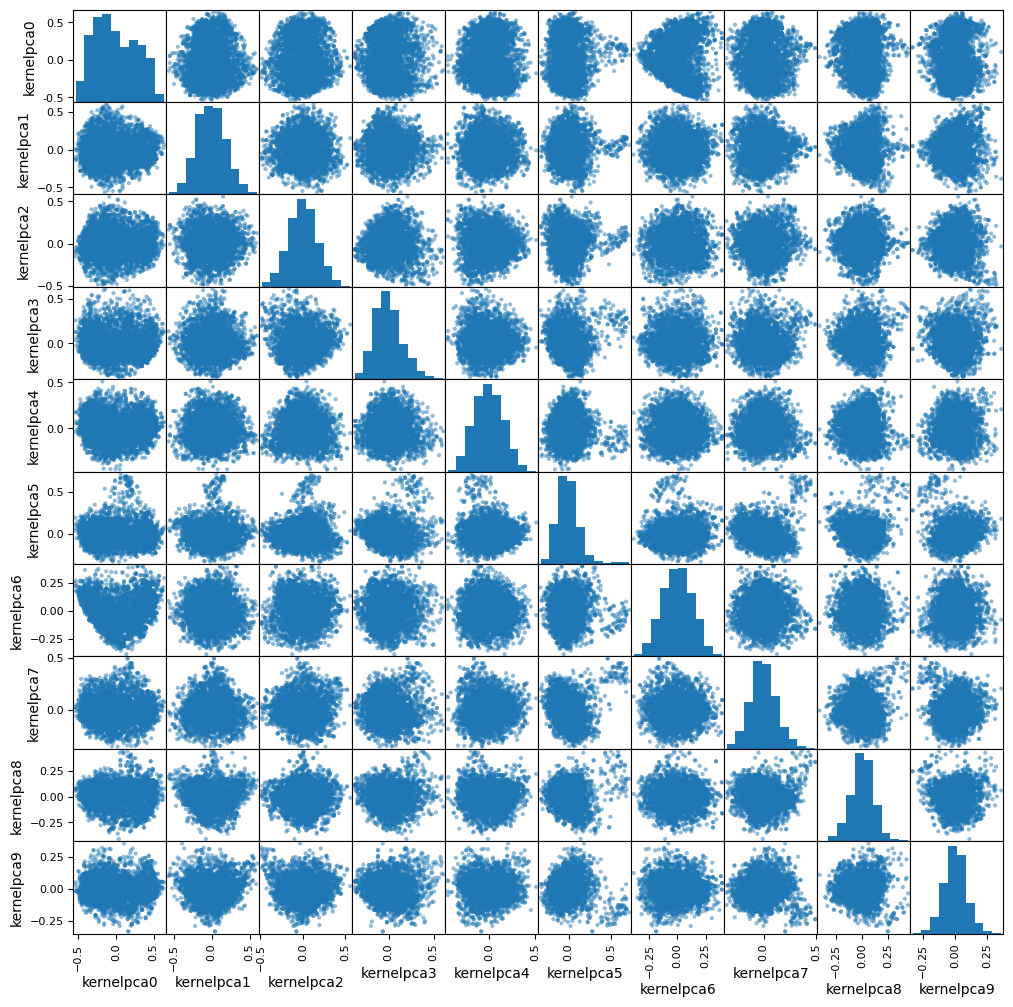

In [22]:
pd.plotting.scatter_matrix(X_pca, figsize=(12,12))
plt.show()

In [26]:
scoring = ["accuracy", "f1_macro"]
k4folds = 5


# name, model = models[0]

# hyperparams = {
#     "standardscaler": [StandardScaler(), MinMaxScaler(), None],
#     "svc": [
#         svm.SVC(random_state=seed),
#         DecisionTreeClassifier(random_state=seed),
#         HistGradientBoostingClassifier(random_state=seed),
#         RandomForestClassifier(random_state=seed),
#     ],
#     # "svc__C": [1, 10, 100, 1000],
# }

hyperparams = {"C": [1, 10, 100]}

# kfold = StratifiedKFold(n_splits=k4folds, random_state=seed, shuffle=True)

clf = GridSearchCV(
    svm.SVC(random_state=seed),
    param_grid=hyperparams,
    n_jobs=-1,
    cv=3,
    scoring=scoring,
    refit="accuracy",
)
clf.fit(X_pca, y_train)
clf.best_params_

{'C': 10}

In [27]:
means = clf.cv_results_["mean_test_accuracy"]
stds = clf.cv_results_["std_test_accuracy"]

for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
    print(f"{mean:0.03f} (+/-{std:0.03}) for {params}\n")
print(clf.cv_results_["mean_fit_time"])

0.567 (+/-0.00225) for {'C': 1}

0.582 (+/-0.00344) for {'C': 10}

0.576 (+/-0.00594) for {'C': 100}

[0.23319427 0.25242186 0.76494702]


In [28]:
selected_model = RandomForestClassifier(random_state=seed)

hyperparams = {
    "n_estimators": [10, 100, 1000],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_features": ["sqrt", "log2", None]
    
}

kfold = KFold(n_splits=k4folds, random_state=seed, shuffle=True)

clf = GridSearchCV(
    selected_model,
    param_grid=hyperparams,
    n_jobs=-1,
    cv=kfold,
    scoring=scoring,
    refit="accuracy",
)
clf.fit(X_pca, y_train)
clf.best_params_

/home/apwood/venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 1000}

In [29]:
means = clf.cv_results_["mean_test_accuracy"]
stds = clf.cv_results_["std_test_accuracy"]

for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
    print(f"{mean:0.03f} (+/-{std:0.03}) for {params}\n")
print(clf.cv_results_["mean_fit_time"])

0.634 (+/-0.0123) for {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 10}

0.672 (+/-0.0115) for {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100}

0.674 (+/-0.0111) for {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 1000}

0.634 (+/-0.0123) for {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 10}

0.672 (+/-0.0115) for {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100}

0.674 (+/-0.0111) for {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 1000}

0.639 (+/-0.00723) for {'criterion': 'gini', 'max_features': None, 'n_estimators': 10}

0.661 (+/-0.0123) for {'criterion': 'gini', 'max_features': None, 'n_estimators': 100}

0.661 (+/-0.00975) for {'criterion': 'gini', 'max_features': None, 'n_estimators': 1000}

0.632 (+/-0.00953) for {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 10}

0.672 (+/-0.014) for {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100}

0.673 (+/

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.62      0.22      0.32        37
           5       0.72      0.71      0.72       282
           6       0.68      0.82      0.74       435
           7       0.79      0.63      0.70       186
           8       0.94      0.42      0.58        36
           9       0.00      0.00      0.00         2

    accuracy                           0.71       980
   macro avg       0.53      0.40      0.44       980
weighted avg       0.72      0.71      0.70       980



/home/apwood/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/apwood/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/apwood/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


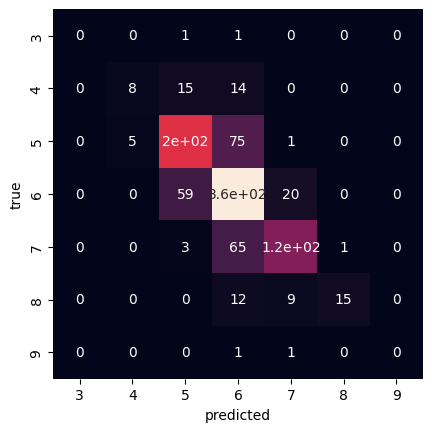

Cohen Kappa Score: 0.5563958240362639


In [73]:
y_true, y_pred = y_test, clf.predict(X_test)

print(classification_report(y_true, y_pred))

df_cm = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=np.unique(y_test),
    index=np.unique(y_test),
)

sns.heatmap(
    df_cm,
    square=True,
    annot=True,
    # fmt="d",
    cbar=False,
)
plt.xlabel("predicted")
plt.ylabel("true")
plt.show()

print("Cohen Kappa Score:", cohen_kappa_score(y_test, y_pred))